In [25]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt


In [2]:
!pip install pyubx2

  Obtaining dependency information for pyubx2 from https://files.pythonhosted.org/packages/1b/38/6790210673025c05f626c5359d4442fcc8477809171f22ab249a4c7c6be9/pyubx2-1.2.39-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/72.8 kB ? eta -:--:--
   ----------- ---------------------------- 20.5/72.8 kB 682.7 kB/s eta 0:00:01
   ---------------------------- ----------- 51.2/72.8 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 72.8/72.8 kB 573.6 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\kippe\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [8]:
from scipy.optimize import minimize
import pickle, numpy as np
import Constants
from Transformations import *
import Minimizing
# with open('storage478046.999877142.log', 'rb') as storage_file:
#     storage = pickle.load(storage_file)
# good_eph = [satellite for satellite in storage.satellites.values()
#                     if satellite.eph is not None and satellite.rawx]
with open('7_calculation579118.000331166.log', 'rb') as eph_file:
    good_eph = pickle.load(eph_file)
    
TOW = 579118.000331166
# print(good_eph)
for sat in good_eph:
    E = np.array(sat.eph_coord)
    A = np.array(sat.alm_coord)
    print(np.linalg.norm(A-E))


# good_eph = good_eph[0:4] + [good_eph[5]]
good_eph = good_eph[:4]
# good_eph = good_eph[:5]

print(len(good_eph))
func = Minimizing.get_minimize_function(good_eph)
me = np.array(list(Constants.ECI) + [0])
print(f'ME: {func(me)}')
xyzt0 = np.array([0, 0, 0, 0])
# xyzt0 = np.array(list(Constants.ECI) + [0])
# xyzt0 = np.array([0, 0, 0, 0, 0])
# xyzt0 = np.array([-1e6, 3.5e6, 5e6, -1e-3])
xyzt = minimize(
                func,
                xyzt0,
                jac=Minimizing.get_minimize_derivative(good_eph),
                options={'disp': True, 'maxiter': 1000},
                tol=1e-12
        )
xyz = xyzt.x[:3]
ecef = eci2ecef(TOW, *xyz)
lla = eci2lla(TOW, *xyz)
jac=Minimizing.get_minimize_derivative(good_eph)
print(f'func: {func(xyzt.x)}')
# print(f'func: {func(xyzt.x + np.array([0, 0, 0, 0]))}')
print(f'jac: {jac(xyzt.x)}')
# print(np.linalg.norm(np.array(xyz)))
# print(np.linalg.norm(np.array(ecef)))
print(f'ECI xyz and dT: {xyzt.x}')
print(f'ECEF xyz: {ecef}')
print(f'LLA calculated:{lla}')
print(f'LLA my valid: {Constants.LLA}')
print(f'Full error: {np.linalg.norm(np.array(ecef) - np.array(Constants.ECEF))}')
a = 0
print('=======================================================')
dT = xyzt.x[-1]
print((TOW/3600) / 24, (TOW/3600) % 24, (TOW %3600)/60)
print(f'dT: {dT}')
for satellite in good_eph:
    print(f'SV: {satellite.svId}')
    print(f'LLA coord of eph: {eci2lla(TOW, *satellite.eph_coord)}, ECI: {satellite.eph_coord}')
    # print(f'LLA coord of alm: {eci2lla(TOW, *satellite.alm_coord)}, ECI: {satellite.alm_coord}')
    R = np.linalg.norm(np.array(satellite.eph_coord) - np.array(Constants.ECI))
    print(f'Pseudorange: {satellite.rawx.prMes}')
    print(f'Calcuated R: {R}')
    print(f'Error: {abs(R-satellite.rawx.prMes)}')
    print(f'Correcet R + c*dT: {R + Constants.c * dT / Minimizing.TimeCoefficient}')
    print(f'Error: {abs(R + Constants.c*dT /Minimizing.TimeCoefficient - satellite.rawx.prMes)}')
    print('-------------------')
# b = 0
    

17640991.25750333
28051607.614606958
30110271.972998984
25213646.081019744
18126821.61147473
19989859.99420869
20719244.11250142
4
ME: 51964060429424.97
         Current function value: 0.000000
         Iterations: 22
         Function evaluations: 46
         Gradient evaluations: 38
func: 2.7755575615628914e-17
jac: (-3.03436691481214e-09, 1.1365900121529576e-08, -5.367058936695426e-09, 4.467255741357803e-09)
ECI xyz and dT: [ 2663122.52389853 -2256019.57218648  4984234.09886257  -515855.32591748]
ECEF xyz: (2833990.304551736, 2037239.514905123, 4984234.098862572)
LLA calculated:(55.18693468067432, 35.71081015251094, -278992.352457156)
LLA my valid: [55.690555555555555, 37.858333333333334, 140]
Full error: 313986.81747776386
6.702754633462569 16.866111203101667 51.96667218609946
dT: -515855.32591747557
SV: 2
LLA coord of eph: (54.778574333712214, -2.599099294810358, 20609476.799185265), ECI: (3083735.0837371247, -15264679.893977871, 22023672.59776174)
Pseudorange: 21287006.71172188


C:\Users\kippe\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [3]:
# xyzt = xyzt.x
def dRho(satellite):
    return Minimizing.calc_rho(satellite, xyzt.x) + Constants.c * xyzt.x[3] / Minimizing.TimeCoefficient - satellite.rawx.prMes
x = list([2 * Constants.c * dRho(satellite) for satellite in good_eph])
print(x)
print(sum(x))

[2.2336278706789017, 0.0, 2.2336278706789017, 0.0]
4.467255741357803


In [30]:
import SatellitesCoordinateCalculator as SCC
from SatellitesCoordinateCalculator import *
N = 2310
i = 4
print(TOW)
print(good_eph[i].alm)
# for k in np.arange(1.03569, 1.03570, 0.000001):
#     print(k)
k = 1.035696
p1 = Acalc_sat_alm(good_eph[i].alm, TOW, N, k)
print(p1)
print(eci2lla(TOW, *p1))
print(good_eph[i].eph)
p2 = SCC.calc_sat_eph(good_eph[i].eph, TOW, N)
print(p2)
print(eci2lla(TOW, *p2))

579118.000331166
[17, 2311, 147456, 0.013410091400146484, 0.008474349975585938, -2.6047928258776665e-09, 5153.6572265625, 0.5290583372116089, -0.4217498302459717, 0.8842452764511108, 0.0007104873657226562, 0.0, 0, 1, datetime.datetime(2024, 4, 20, 19, 51, 1, 480657, tzinfo=<DstTzInfo 'Europe/Moscow' MSK+3:00:00 STD>)]
1.035696
-173137.99966883403
2.2100573269787347
(-15490225.905241322, -4014787.60301065, 21593484.119341377)
(53.50304789949836, -89.4898395210575, 20512127.890603006)
[17, 2310, 583184, 583184, 8, 8, 232, -1.0118128557223827e-10, -2.5535200620652176e-09, -54.9375, 291.0625, 4.734843969345093e-06, -2.635642886161804e-06, 1.3969838619232178e-07, 1.9185245037078857e-07, 1.4808847481617704e-09, 0.3084875871427357, 0.013404096011072397, 5153.707925796509, -0.9651154428720474, 0.5678392145782709, -0.42194465594366193, 1.0803341865539551e-07, 0.0, -1.0231815394945443e-12, 0.0007107830606400967, 0, 0, datetime.datetime(2024, 4, 20, 19, 51, 24, 476365, tzinfo=<DstTzInfo 'Europe/M

In [10]:
def check_time(time, *args, **kwargs):
    half_week = 302400.0
    if time > half_week:
        time -= 2 * half_week
    elif time < - half_week:
        time += 2 * half_week
    return time

def Acalc_sat_alm(ALM: list or None, time, N, k):
    if ALM is None or not time or not N:
        return None
    # SV_ID, week, Toa, e, delta_i, Wdot, sqrtA, W0, w, M0, af0, af1, health, Data_ID, receiving_time = ALM
    SV_ID = ALM[0]  # ID спутника
    N0a = ALM[1]  # номер недели передаваемых данных
    Toa = ALM[2]  # опорное время внутри недели N, на которую передаются данные альманах
    e = ALM[3]  # эксцентриситет
    di = ALM[4] * pi  # rad, поправка к наклонению
    OmegaDot = ALM[5] * pi  # rad/s, скорость прецессии орбиты
    sqrtA = ALM[6]  # корень из большей полуоси
    Omega0 = ALM[7] * pi  # rad Угол восходящего узла на момент начала недели N
    omega = ALM[8] * pi  # rad аргумент перигея
    M0 = ALM[9] * pi  # rad средняя аномалия на эпоху Toa
    af0 = ALM[10]  #
    af1 = ALM[11]  #
    health = ALM[12]  #
    Data_ID = ALM[13]  #
    receiving_time: datetime = ALM[14]  # время принятия сигнала

    CORRECTION_FACTOR = k#1.1
    print(CORRECTION_FACTOR)

    OmegaEarthDot = Constants.OmegaEarthDot * CORRECTION_FACTOR

    # mu = 3.9860044 * 1e14  # m^3/s^2 гравитационная постоянная для земли WGS-84
    # OmegaEarthDot = 7.2921151467 * 10e-5  # rad/s скорость вращения земли WGS-84

    i0 = 0.30 * pi  # rad

    a = sqrtA ** 2  # большая полуось
    n0 = sqrt(Constants.mu / a ** 3)  # rad/s вычисленное среднее перемещение

    # TODO: добавить поправки генераторов
    tk = (N - N0a) * 604800 + time - Toa  # + 3600 * 6
    tk = check_time(tk)
    print(tk)

    Mk = M0 + n0 * tk  # средняя аномалия
    ## Решение уравнения Mk = Ek - e * sin(Ek)
    Ek = Mk  # rad
    for i in range(20):
        Ek = Ek + (Mk - Ek + e * sin(Ek)) / (1 - e * cos(Ek))
    nu_k = atan2(
        sqrt(1 - e * e) * sin(Ek) / (1 - e * cos(Ek)),
        (cos(Ek) - e) / (1 - e * cos(Ek))
    )
    # r_k = a * (1 - e * cos(Ek)) / (1 + e * cos(Ek))
    r_k = a * (1 - e * cos(Ek))
    ik = i0 + di
    Omega_k = Omega0 + (OmegaDot - OmegaEarthDot) * tk - OmegaEarthDot * Toa
    print(Omega_k % pi)
    p = a * (1 - e * e)
    Vr = sqrt(Constants.mu / p) * e * sin(nu_k)
    Vn = sqrt(Constants.mu / p) * (1 + e * cos(nu_k))
    u_k = omega + nu_k

    X = r_k * (cos(u_k) * cos(Omega_k) - sin(u_k) * sin(Omega_k) * cos(ik))
    Y = r_k * (cos(u_k) * sin(Omega_k) + sin(u_k) * cos(Omega_k) * cos(ik))
    Z = r_k * sin(u_k) * sin(ik)

    return X, Y, Z

In [3]:
import pymap3d as pm
import numpy as np
import pandas as pd
from math import pi, sqrt, sin, atan, atan2, cos, tan
from Transformations import *
from Constants import StartDate, LLA
from datetime import timedelta, datetime

C:\Users\kippe\AppData\Local\Temp\ipykernel_12132\1963245229.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
def check_t(time, *args, **kwargs):
    half_week = 302400.0
    if time > half_week:
        time -= 2 * half_week
    elif time < - half_week:
        time += 2 * half_week
    return time
def calc_sat_alm(ALM: list, time, N, k = 1):
    # SV_ID, week, Toa, e, delta_i, Wdot, sqrtA, W0, w, M0, af0, af1, health, Data_ID, receiving_time = ALM
    SV_ID = ALM[0]  # ID спутника
    N0a = ALM[1]  # номер недели передаваемых данных
    Toa = ALM[2]  # опорное время внутри недели N, на которую передаются данные альманах
    e = ALM[3]  # эксцентриситет
    di = ALM[4] * pi  # rad, поправка к наклонению
    OmegaDot = ALM[5] * pi  # rad/s, скорость прецессии орбиты
    sqrtA = ALM[6]  # корень из большей полуоси
    Omega0 = ALM[7] * pi  # rad Угол восходящего узла на момент начала недели N
    omega = ALM[8] * pi  # rad аргумент перигея
    M0 = ALM[9] * pi  # rad средняя аномалия на эпоху Toa
    af0 = ALM[10]  #
    af1 = ALM[11]  #
    health = ALM[12]  #
    Data_ID = ALM[13]  #
    receiving_time: datetime = ALM[14]  # время принятия сигнала

    mu = 3.9860044 * 1e14  # m^3/s^2 гравитационная постоянная для земли WGS-84
    # OmegaEathDot = 7.2921151467 * 10e-5 * 1.1 # rad/s скорость вращения земли WGS-84
    from Constants import OmegaEarthDot
    OmegaEathDot = OmegaEarthDot * 1.1
    
    i0 = 0.30 * pi  # rad

    a = sqrtA ** 2  # большая полуось
    n0 = sqrt(mu / a ** 3)  # rad/s вычисленное среднее перемещение

    
    tk = (N - N0a) * 604800 + time - Toa 
    tk = tk#+ 2.6 * 60 * 60
    Mk = M0 + n0 * tk  # средняя аномалия
    ## Решение уравнения Mk = Ek - e * sin(Ek)
    Ek = Mk  # rad
    for i in range(20):
        Ek = Ek + (Mk - Ek + e * sin(Ek)) / (1 - e * cos(Ek))
    nu_k = atan2(
        sqrt(1 - e * e) * sin(Ek) / (1 - e * cos(Ek)),
        (cos(Ek) - e) / (1 - e * cos(Ek))
    )
    r_k = a * (1 - e * cos(Ek)) / (1 + e * cos(Ek))
    ik = i0 + di
    Omega_k = Omega0 + (OmegaDot - OmegaEathDot) * tk - OmegaEathDot * Toa #+ 0.1 * OmegaEarthDot * time
    # print(Omega0 * 180/pi)
    # print((OmegaDot - OmegaEathDot) * tk * 180 / pi)
    # print(tk)
    # print( (-OmegaEathDot * Toa * 180 / pi) % 360)
    # print((Omega_k * 180 / pi) %  360)
    u_k = omega + nu_k

    X = r_k * (cos(u_k) * cos(Omega_k) - sin(u_k) * sin(Omega_k) * cos(ik))
    Y = r_k * (cos(u_k) * sin(Omega_k) + sin(u_k) * cos(Omega_k) * cos(ik))
    Z = r_k * sin(u_k) * sin(ik)

    return (X, Y, Z)

def calc_sat_eph(EPH: list, time, N, flag=True):
    SV_ID = EPH[0]
    Noe = EPH[1]
    Toe = EPH[2]
    Toc = EPH[3]
    IODE1 = EPH[4]
    IODE2 = EPH[5]
    IODC = EPH[6]
    IDOT = EPH[7] * pi
    OmegaDot = EPH[8] * pi
    Crs = EPH[9]
    Crc = EPH[10]
    Cus = EPH[11]
    Cuc = EPH[12]
    Cis = EPH[13]
    Cic = EPH[14]
    dn = EPH[15] * pi
    i0 = EPH[16] * pi
    e = EPH[17]
    sqrtA = EPH[18]
    M0 = EPH[19] * pi
    Omega0 = EPH[20] * pi
    omega = EPH[21] * pi
    Tgd = EPH[22]
    af2 = EPH[23]
    af1 = EPH[24]
    af0 = EPH[25]
    health = EPH[26]
    accuracy = EPH[27]
    receiving_time = EPH[28]
    
    CORRECTION_FACTOR = 1.1
    

    a = sqrtA ** 2  # большая полуось
    n0 = sqrt(Constants.mu / a ** 3)  # rad/s вычисленное среднее перемещение
    n = n0 + dn  # скорректированное средне движение
    t = time
    # TODO: добавить поправки генераторов
    tk = 0 * 604800 + time - Toe
    print(tk)
    dt = check_t(time - Toc)
    satNr = (af2 * dt + af1) * dt + af0 - Tgd
    time = time - satNr
    tk = check_t(time - Toe)
    print(tk)

    Mk = M0 + n * tk  # средняя аномалия
    ## Решение уравнения Mk = Ek - e * sin(Ek)
    Ek = Mk  # rad
    for i in range(20):
        Ek = Ek + (Mk - Ek + e * sin(Ek)) / (1 - e * cos(Ek))

    nu_k = atan2(
        sqrt(1 - e * e) * sin(Ek) / (1 - e * cos(Ek)),
        (cos(Ek) - e) / (1 - e * cos(Ek))
    )
    Phi_k = nu_k + omega  # аргумент lat
    r_k = a * (1 - e * cos(Ek))
    ik = i0 + IDOT * tk
    OmegaEarthDot = Constants.OmegaEarthDot * CORRECTION_FACTOR
    Omega_k = Omega0 + (OmegaDot - OmegaEarthDot) * tk - OmegaEarthDot * Toe
    du_k = Cuc * cos(2 * Phi_k) + Cus * sin(2 * Phi_k)
    dr_k = Crc * cos(2 * Phi_k) + Crs * sin(2 * Phi_k)
    di_k = Cic * cos(2 * Phi_k) + Cis * sin(2 * Phi_k)

    u_k = Phi_k + du_k
    r_k = r_k + dr_k
    ik = ik + di_k

    X = r_k * (cos(u_k) * cos(Omega_k) - sin(u_k) * sin(Omega_k) * cos(ik))
    Y = r_k * (cos(u_k) * sin(Omega_k) + sin(u_k) * cos(Omega_k) * cos(ik))
    Z = r_k * sin(u_k) * sin(ik)

    return X, Y, Z

In [11]:
moscow_time_hours = 5

lat =  -9.8
lon = 74.4

azim = 141
elev = 3
rad = 25000


# moscow_time_hours = 23
# 
# lat = 10.5
# lon = -15.7
# 
# azim = 244
# elev = 15
# rad = 24173


print(f'Moscow time: {moscow_time_hours}:00')
print(f'UTC time: {moscow_time_hours - 3}:00')
TOW = moscow_time_hours * 3600 - 3600 * 3
# alm =[9, 2310, 233472, 0.0026683807373046875, 0.0048961639404296875, -2.5029294192790985e-09, 5153.63623046875, -0.4584728479385376, 0.635661244392395, 0.9340482950210571, 0.00016307830810546875, 1.4551915228366852e-11, 0, 1, datetime.now()]
alm = [9, 2310, 147456, 0.002669811248779297, 0.004894256591796875, -2.4883775040507317e-09, 5153.63623046875, -0.4582533836364746, 0.6358199119567871, 0.940352201461792, 0.00016117095947265625, 1.4551915228366852e-11, 0, 1, datetime.now()] 

eph =[9, 262, 0, 0, 74, 74, 2, 7.537437340943143e-11, -2.543060872994829e-09, -25.65625, 221.875, 8.085742592811584e-06, -1.4491379261016846e-06, -7.264316082000732e-08, -3.5390257835388184e-08, 1.463831722503528e-09, 0.3048875015228987, 0.0026726502692326903, 5153.685857772827, 0.09409773629158735, -0.4578785211779177, 0.6360140475444496, 9.313225746154785e-10, 0.0, 1.3642420526593924e-11, 0.00015946431085467339, 0, 0, datetime.now()]

ecef1 = np.array(lla2ecef(lat, lon, 20200 * 1000))
# ecef1 = ecef2eci(time, *eci1)

print(f'ECEF from site LLA: {list(map(int, np.array(ecef1) / 1000))} km')

ecef2 = pm.aer2ecef(azim, elev, rad * 1000, *LLA)

print(f'ECEF from site AER: {list(map(int, np.array(ecef2) / 1000))} km')

eci3 = calc_sat_alm(alm, TOW, 2310)
# print(f'ECI from ALM: {list(map(int, np.array(eci3) / 1000))}')
ecef3 = eci2ecef(TOW, *eci3)
print(f'ECEF from ALM: {list(map(int, np.array(ecef3) / 1000))} with Earth k = {1.1}')

eci4 = calc_sat_eph(eph, TOW, 2310)
# print(f'ECI from ALM: {list(map(int, np.array(eci3) / 1000))}')
ecef4 = eci2ecef(TOW, *eci4)
print(f'ECEF from ALM: {list(map(int, np.array(ecef4) / 1000))} with Earth k = {1.1}')
xyz = ecef4
print(xyz)

Moscow time: 5:00
UTC time: 2:00
ECEF from site LLA: [7043, 25226, -4516] km
ECEF from site AER: [6438, 24904, -4610] km
ECEF from ALM: [7031, 25186, -4471] with Earth k = 1.1
7200
7199.999840438395
ECEF from ALM: [7035, 25201, -4473] with Earth k = 1.1
(7035217.596797438, 25201843.625571836, -4473310.712375888)


In [9]:
import numpy as np
from math import sqrt
def calc_dist(elev):
    r = Constants.ApproximateEarthRadius
    h = Constants.GPSAltitude
    if elev == -91:
        return np.nan
    dist = 0.5 * (
            np.sqrt(2) * np.sqrt(2 * h * h + 4 * h * r + r * r - r * r * np.cos(2 * elev * np.pi / 180)) -
            2 * r * np.sin(elev * np.pi / 180))
    return dist * 1000
from Transformations import Raer2ned
import Constants
def calc_dist2(azim, elev):
    Re = Raer2ned(Constants.LLA[0], Constants.LLA[1], azim, elev)
    a2 = (Constants.a + Constants.GPSAltitude) / 1000
    b2 = (Constants.b + Constants.GPSAltitude) / 1000
    x, y, z = lla2ecef(*Constants.LLA)
    a = (Re[0]**2 + Re[1]**2)/a2**2 + Re[2]**2/b2**2
    b = (x*Re[0] + y*Re[1])/a2**2 + z*Re[2]/b2**2
    c = (x**2+y**2)/a2**2 + z**2/b2**2 - 1 * 1000**2
    
    print(a, b, c)
    D = b**2 - a * c
    R = (b + sqrt(D)) / a * 1000
    print(R)
    return 1 / sqrt( Re[0]**2/Constants.a**2 + Re[1]**2/Constants.a**2 + Re[2]**2/Constants.b**2)
print(calc_dist(36))
print(calc_dist2(193, 36))

22329386.161617927
2.442704117014386e-08 0.09178705639247853 -6274.821828282904
7549227871.433087
6378099.537119053


In [10]:
from Transformations import aer2ecef, lla2ecef
import Constants
print(aer2ecef(206, 56, 21068*1000, *Constants.LLA))
print(lla2ecef(31.3, 24.2, 20222*1000))

ImportError: cannot import name 'aer2ecef' from 'Transformations' (C:\Users\kippe\PycharmProjects\raspi_GPS_2\Transformations.py)

In [ ]:
def Raer2ned(phi, lam, azim, elev):
    phi = np.radians(phi)
    lam = np.radians(lam)
    az_rad = radians(azim)
    el_rad = radians(elev)
    return np.array([
        [-sin(phi) * cos(lam), -sin(phi) * sin(lam), cos(phi)],
        [-sin(lam), cos(lam), 0],
        [-cos(phi) * cos(lam), -cos(phi) * sin(lam), -sin(phi)],
    ]) @ [cos(az_rad) * cos(el_rad), sin(az_rad) * cos(el_rad), -sin(el_rad)]


def aer2ecef(azim, elev, dist, lat, lon, alt):
    UVW = Raer2ned(lat, lon, azim, elev) * dist
    XYZ = lla2ecef(lat, lon, alt)
    ECEF = UVW + XYZ
    return ECEF

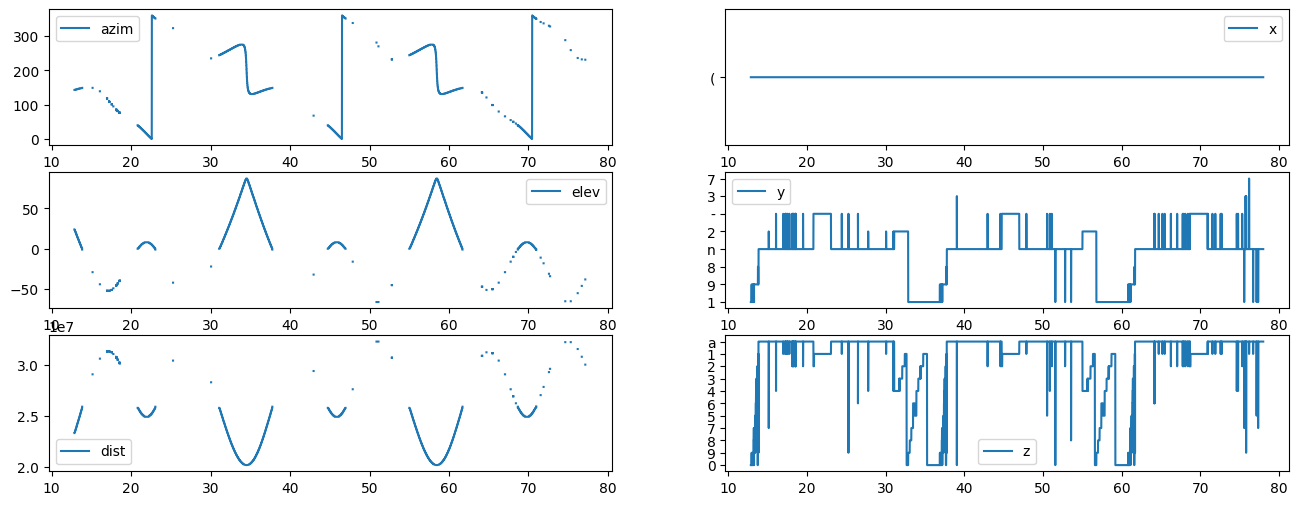

In [60]:
df = pd.read_csv('sat12.csv', sep=';')#, names=['tow', 'azim', 'elev', 'dist', 'x', 'y', 'z'], sep=';')
print(df.tail())
from math import atan, pi


fig, axs = plt.subplots(3, 2, figsize=(16, 6))
axs[0, 0].plot(df.TOW/3600, df.azim, label='azim')#, s=0.3)
axs[0, 0].legend()
axs[1, 0].plot(df.TOW/3600, df.elev, label='elev')#, s=0.3)
axs[1, 0].legend()
axs[2, 0].plot(df.TOW/3600, df.dist, label='dist')#, s=0.3)
axs[2, 0].legend()
axs[0, 1].plot(df.TOW/3600, df.ubx_ecef.apply(lambda x: x[0]), label='x')#, s=0.3)
axs[0, 1].legend()
axs[1, 1].plot(df.TOW/3600, df.ubx_ecef.apply(lambda x: x[1]), label='y')#, s=0.3)
axs[1, 1].legend()
axs[2, 1].plot(df.TOW/3600, df.ubx_ecef.apply(lambda x: x[2]), label='z')#, s=0.3)
axs[2, 1].legend()
plt.savefig('sat12dasd.png')
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DF = pd.read_csv('sat_raw_calc_data.txt', sep=';', header=None,
                     names=['svId', 'gnssId', 'TOW', 'alm_x', 'alm_y', 'alm_z', 'eph_x', 'eph_y', 'eph_z',
                            'elev', 'azim', 'doMes', 'cpMes', 'prMes'])
DF = DF[DF.gnssId == 'GNSS.GPS']




C:\Users\kippe\AppData\Local\Temp\ipykernel_170088\3806937105.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


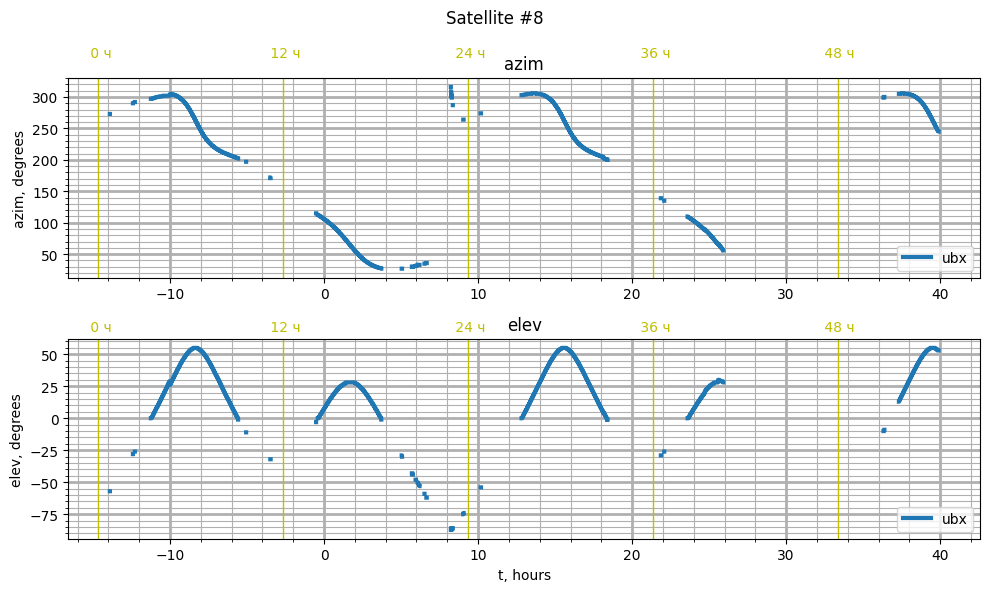

In [4]:
import pymap3d as pm
from Constants import LLA
from Constants import StartDate
from datetime import timedelta

NUM_SAT = 8
df = DF[DF.svId == NUM_SAT]
df = df[df.elev != -91]

# def func(row):
#     breakpoint()
#     res = pm.eci2aer(row.alm_x, row.alm_y, row.alm_z, *LLA, row.TOW/3600)
#     return res
# df['aer_alm'] = df.apply(func, axis=1)

# df['aer_alm'] = df.apply(
#     lambda row: pm.eci2aer(row.alm_x, row.alm_y, row.alm_z, *LLA, StartDate + timedelta(seconds=24*3600)), 
#     axis=1)
# df['aer_eph'] = df.apply(
#     lambda row: pm.eci2aer(row.eph_x, row.eph_y, row.eph_z, *LLA, StartDate + timedelta(seconds=24*3600)), 
#     axis=1)

df.loc[df['TOW'] > 50 * 3600, 'TOW'] -= 3600 * 24 * 7
htime = df.TOW / 3600

fig, axs = plt.subplots(2, figsize=(10, 6))
fig.suptitle(f'Satellite #{NUM_SAT}')

axs[0].plot(df.TOW/3600, df.azim, linewidth=3, label='ubx')#, s=0.3)
# axs[0].plot(df.TOW/3600, df.aer_alm.apply(lambda x: x[0]), linewidth=3, label='alm')#, s=0.3)
# axs[0].plot(df.TOW/3600, df.aer_eph.apply(lambda x: x[0]), linewidth=3, label='eph')#, s=0.3)
axs[0].legend()

axs[1].plot(df.TOW/3600, df.elev, linewidth=3, label='ubx')#, s=0.3)
# axs[1].plot(df.TOW/3600, df.aer_alm.apply(lambda x: x[1]), linewidth=3, label='alm')#, s=0.3)
# axs[1].plot(df.TOW/3600, df.aer_eph.apply(lambda x: x[1]), linewidth=3, label='eph')#, s=0.3)
axs[1].legend()

for i in range(2):
    ymax = axs[i].get_ylim()[1]
    for t in np.arange(min(htime), max(htime), 12.0):
        axs[i].axvline(x=t, color='y', linewidth=1)
        # axs[i].annotate(f'{round(t - min(htime)): 2} ч', (t, ymax*0.95), color='y')
        axs[i].text(t, ymax * 1.1, f'{round(t - min(htime)): 2} ч', color='y', ha='center')
    axs[i].grid(which='minor')
    axs[i].grid(which='major', linewidth=2)
    axs[i].minorticks_on()
axs[0].set_title('azim')
axs[1].set_title('elev')
axs[1].set_xlabel('t, hours')
axs[0].set_ylabel('azim, degrees')
axs[1].set_ylabel('elev, degrees')
plt.tight_layout()

plt.savefig('sat_azim_elev.png', dpi=600)
plt.show()

In [7]:
import pymap3d as pm
import numpy as np
from Transformations import *
from Constants import StartDate, LLA
from datetime import timedelta
lat = 10
lon = 15
# time = 3600 * 3

azim = 0
elev = 0
rad = 0

ecef1 = np.array(lla2ecef(lat, lon, 20e6))
# ecef1 = ecef2eci(time, *eci1)

print(f'ECEF from site LLA: {list(map(int, np.array(ecef1) / 1000))} km')

ecef2 = pm.aer2ecef(azim, elev, rad, *LLA)

print(f'ECEF from site AER: {list(map(int, np.array(ecef1) / 1000))} km')

ECEF from site LLA: [25092, 6723, 4573] km
ECEF from site AER: [25092, 6723, 4573] km


In [46]:
df = pd.read_csv('sat12.csv', sep=';')
df.head()

,Unnamed: 0,TOW,az,el,az_cor,el_cor
0,0,46308.999,143.0,24.0,315.253911,-29.621162
1,1,46309.999,143.0,24.0,315.249931,-29.619684
2,2,46311.000,143.0,24.0,315.245946,-29.618204
3,3,46312.000,143.0,24.0,315.241966,-29.616725
4,4,46313.000,143.0,24.0,315.237986,-29.615247


C:\Users\kippe\AppData\Local\Temp\ipykernel_49140\2947557027.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.htime = df.TOW / 3600


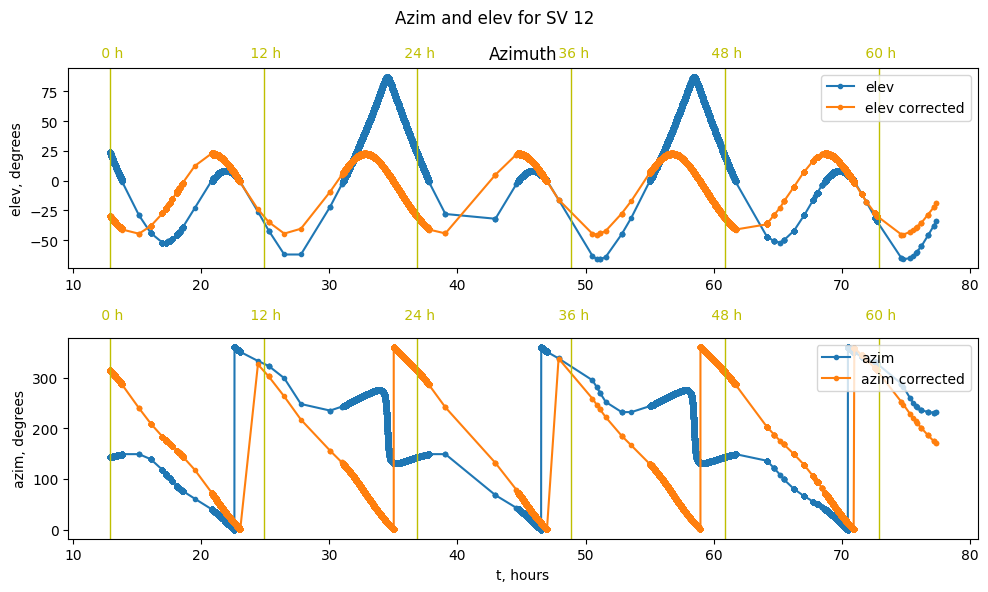

In [47]:
df.htime = df.TOW / 3600
fig, axs = plt.subplots(2, figsize=(10, 6))
fig.suptitle('Azim and elev for SV 12')

axs[0].plot(df.htime, df.el, label='elev', marker='.')
axs[1].plot(df.htime, df.az, label='azim', marker='.')
axs[0].plot(df.htime, df.el_cor, label='elev corrected', marker='.')
axs[1].plot(df.htime, df.az_cor, label='azim corrected', marker='.')

for i in range(2):
    ymax = axs[i].get_ylim()[1]
    for t in np.arange(min(df.htime), max(df.htime), 12.0):
        axs[i].axvline(x=t, color='y', linewidth=1)
        # axs[i].annotate(f'{round(t - min(htime)): 2} ч', (t, ymax*0.95), color='y')
        axs[i].text(t, ymax * 1.1, f'{round(t - min(df.htime)): 2} h', color='y', ha='center')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_title('Elevation')
axs[0].set_title('Azimuth')
axs[1].set_xlabel('t, hours')
axs[0].set_ylabel('elev, degrees')
axs[1].set_ylabel('azim, degrees')
plt.tight_layout()
plt.savefig('sat12.png', dpi=500)
plt.show()


In [186]:
from datetime import datetime, timedelta
from math import pi, sqrt, sin, atan, atan2, cos, tan

import numpy as np
alm = [8, 2310, 147456, 0.009456157684326172, 0.0035114288330078125, -2.5247572921216488e-09, 5153.56689453125, 0.5389893054962158, 0.11286938190460205, 0.7948415279388428, 0.0001239776611328125, 2.1827872842550278e-11, 0, 1, datetime.now()]
eph = [8, 261, 583200, 583200, 27, 27, 10, 6.707523425575346e-12, -2.567389856267255e-09, 109.90625, 287.1875, 4.697591066360474e-06, 5.5730342864990234e-06, -8.754432201385498e-08, -1.0803341865539551e-07, 1.4808847481617704e-09, 0.3035227810032666, 0.009448226657696068, 5153.622440338135, 0.9459900539368391, 0.5777560574933887, 0.1125011807307601, 4.6566128730773926e-09, 0.0, 2.319211489520967e-11, 0.00011975038796663284, 0, 0, datetime.now()]
alm = [9, 2310, 147456, 0.002669811248779297, 0.004894256591796875, -2.4883775040507317e-09, 5153.63623046875, -0.4582533836364746, 0.6358199119567871, 0.940352201461792, 0.00016117095947265625, 1.4551915228366852e-11, 0, 1, datetime.now()]

alm =[9, 2310, 233472, 0.0026683807373046875, 0.0048961639404296875, -2.5029294192790985e-09, 5153.63623046875, -0.4584728479385376, 0.635661244392395, 0.9340482950210571, 0.00016307830810546875, 1.4551915228366852e-11, 0, 1, datetime.now()]

eph =[9, 262, 0, 0, 74, 74, 2, 7.537437340943143e-11, -2.543060872994829e-09, -25.65625, 221.875, 8.085742592811584e-06, -1.4491379261016846e-06, -7.264316082000732e-08, -3.5390257835388184e-08, 1.463831722503528e-09, 0.3048875015228987, 0.0026726502692326903, 5153.685857772827, 0.09409773629158735, -0.4578785211779177, 0.6360140475444496, 9.313225746154785e-10, 0.0, 1.3642420526593924e-11, 0.00015946431085467339, 0, 0, datetime.now()]

def check_t(time, *args, **kwargs):
    half_week = 302400.0
    if time > half_week:
        time -= 2 * half_week
    elif time < - half_week:
        time += 2 * half_week
    return time


In [3]:
def calc_sat_alm(ALM: list, time, N):
    # SV_ID, week, Toa, e, delta_i, Wdot, sqrtA, W0, w, M0, af0, af1, health, Data_ID, receiving_time = ALM
    SV_ID = ALM[0]  # ID спутника
    N0a = ALM[1]  # номер недели передаваемых данных
    Toa = ALM[2]  # опорное время внутри недели N, на которую передаются данные альманах
    e = ALM[3]  # эксцентриситет
    di = ALM[4] * pi  # rad, поправка к наклонению
    OmegaDot = ALM[5] * pi  # rad/s, скорость прецессии орбиты
    sqrtA = ALM[6]  # корень из большей полуоси
    Omega0 = ALM[7] * pi  # rad Угол восходящего узла на момент начала недели N
    omega = ALM[8] * pi  # rad аргумент перигея
    M0 = ALM[9] * pi  # rad средняя аномалия на эпоху Toa
    af0 = ALM[10]  #
    af1 = ALM[11]  #
    health = ALM[12]  #
    Data_ID = ALM[13]  #
    receiving_time: datetime = ALM[14]  # время принятия сигнала

    mu = 3.9860044 * 1e14  # m^3/s^2 гравитационная постоянная для земли WGS-84
    OmegaEathDot = 7.2921151467 * 10e-5  # rad/s скорость вращения земли WGS-84
    i0 = 0.30 * pi  # rad

    a = sqrtA ** 2  # большая полуось
    n0 = sqrt(mu / a ** 3)  # rad/s вычисленное среднее перемещение

    t = time
    # TODO: добавить поправки генераторов
    tk = (N - N0a) * 604800 + time - Toa#+ 3600 * 6

    Mk = M0 + n0 * tk  # средняя аномалия
    ## Решение уравнения Mk = Ek - e * sin(Ek)
    Ek = Mk  # rad
    for i in range(20):
        Ek = Ek + (Mk - Ek + e * sin(Ek)) / (1 - e * cos(Ek))
    nu_k = atan2(
        sqrt(1 - e * e) * sin(Ek) / (1 - e * cos(Ek)),
        (cos(Ek) - e) / (1 - e * cos(Ek))
    )
    r_k = a * (1 - e * cos(Ek))
    ik = i0 + di
    Omega_k = Omega0 + (OmegaDot - OmegaEathDot) * tk - OmegaEathDot * Toa
    p = a * (1 - e * e)
    Vr = sqrt(mu / p) * e * sin(nu_k)
    Vn = sqrt(mu / p) * (1 + e * cos(nu_k))
    u_k = omega + nu_k

    X = r_k * (cos(u_k) * cos(Omega_k) - sin(u_k) * sin(Omega_k) * cos(ik))
    Y = r_k * (cos(u_k) * sin(Omega_k) + sin(u_k) * cos(Omega_k) * cos(ik))
    Z = r_k * sin(u_k) * sin(ik)


    V0x = Vr * (cos(u_k) * cos(Omega_k) - sin(u_k) * sin(Omega_k) * cos(ik)) \
          - Vn * (sin(u_k) * cos(Omega_k) + cos(u_k) * sin(Omega_k) * cos(ik))
    V0y = Vr * (cos(u_k) * sin(Omega_k) + sin(u_k) * cos(Omega_k) * cos(ik)) \
          - Vn * (sin(u_k) * sin(Omega_k) - cos(u_k) * cos(Omega_k) * cos(ik))
    V0z = Vr * sin(u_k) * sin(ik) \
          + Vn * cos(u_k) * sin(ik)

    Vx = V0x + 0*OmegaEathDot * Y
    Vy = V0y - 0*OmegaEathDot * X
    Vz = V0z
    return (X, Y, Z, Vx, Vy, Vz)

In [245]:
ALM = alm
time = 3600 * 4
N = 2310

SV_ID = ALM[0]  # ID спутника
N0a = ALM[1]  # номер недели передаваемых данных
Toa = ALM[2]  # опорное время внутри недели N, на которую передаются данные альманах
e = ALM[3]  # эксцентриситет
di = ALM[4] * pi  # rad, поправка к наклонению
OmegaDot = ALM[5] * pi * (3600*24)  # rad/s, скорость прецессии орбиты
sqrtA = ALM[6]  # корень из большей полуоси
Omega0 = ALM[7] * pi  # rad Угол восходящего узла на момент начала недели N
omega = ALM[8] * pi  # rad аргумент перигея
M0 = ALM[9] * pi  # rad средняя аномалия на эпоху Toa
af0 = ALM[10]  #
af1 = ALM[11]  #
health = ALM[12]  #
Data_ID = ALM[13]  #
receiving_time: datetime = ALM[14]  # время принятия сигнала

mu = 3.9860044 * 1e14  # m^3/s^2 гравитационная постоянная для земли WGS-84
OmegaEathDot = 7.2921151467 * 10e-5 # rad/s скорость вращения земли WGS-84
i0 = 0.30 * pi  # rad

a = sqrtA ** 2  # большая полуось
n0 = sqrt(mu / a ** 3)  # rad/s вычисленное среднее перемещение
t = time
# TODO: добавить поправки генераторов
tk = (N - N0a) * 604800 + time - Toa#+ 3600 * 6

Mk = M0 + n0 * tk  # средняя аномалия

## Решение уравнения Mk = Ek - e * sin(Ek)
Ek = Mk  # rad
for i in range(20):
    Ek = Ek + (Mk - Ek + e * sin(Ek)) / (1 - e * cos(Ek))
    # Ek = Mk - e * sin(Ek)
# print((Ek % pi) / pi * 180)
nu_k = atan2(
    sqrt(1 - e * e) * sin(Ek),# / (1 - e * cos(Ek)),
    (cos(Ek) - e)# / (1 - e * cos(Ek))
)
r_k = a * (1 - e * cos(Ek))
ik = i0 + di
Omega_k = Omega0 + (OmegaDot - OmegaEathDot) * tk - OmegaEathDot * Toa #- 0.095*OmegaEathDot * time

u_k = omega + nu_k

X = r_k * (cos(u_k) * cos(Omega_k) - sin(u_k) * sin(Omega_k) * cos(ik))
Y = r_k * (cos(u_k) * sin(Omega_k) + sin(u_k) * cos(Omega_k) * cos(ik))
Z = r_k * sin(u_k) * sin(ik)
# print(tk)
# print(time)
# print(r_k)
# print(cos(u_k))
# print(sin(u_k)  * cos(ik))
print(X, Y, Z)
# for TOW = 4 Omega_k = -1.6905563119681734 или -0.421244997364088 радиан или 96.86 или -24.14 градуса
# print(Omega_k)
# print((Omega_k*180/pi) % 360)
# import pymap3d as pm
# print(pm.eci2ecef(X, Y, Z, datetime(2024, 4, 14, 7, 0, 0)))

-16064521.467361048 4657822.309377097 -20698882.08704459
136.89196972358624
283.33211439413844


In [187]:
EPH = eph
# time = 576018 # 60 градусов
time = 2 * 3600

# SV_ID = EPH[0]
# Noe = EPH[1]
Toe = EPH[2]
# Toc = EPH[3]
# IODE1 = EPH[4]
# IODE2 = EPH[5]
# IODC = EPH[6]
IDOT = 0#EPH[7] * pi
OmegaDot = EPH[8] * pi
Crs = 0#EPH[9]
Crc = 0#EPH[10]
Cus = 0#EPH[11]
Cuc = 0#EPH[12]
Cis = 0#EPH[13]
Cic = 0#EPH[14]
dn = 0#EPH[15] * pi
i0 = EPH[16] * pi
e = EPH[17]
sqrtA = EPH[18]
M0 = EPH[19] * pi
Omega0 = EPH[20] * pi 
omega = EPH[21] * pi
# Tgd = EPH[22]
# af2 = EPH[23]
# af1 = EPH[24]
# af0 = EPH[25]
# health = EPH[26]
# accuracy = EPH[27]
# receiving_time = EPH[28]

# print(M0 / pi * 180)

mu = 3.9860044 * 1e14  # m^3/s^2 гравитационная постоянная для земли WGS-84
OmegaEathDot = 7.2921151467 * 10e-5  # rad/s скорость вращения земли WGS-84

a = sqrtA ** 2  # большая полуось
n0 = sqrt(mu / a ** 3)  # rad/s вычисленное среднее перемещение
n = n0 + dn  # скорректированное средне движение
t = time
# TODO: добавить поправки генераторов
tk = 0 * 604800 + time - Toe

Mk = M0 + n * tk  # средняя аномалия
## Решение уравнения Mk = Ek - e * sin(Ek)
Ek = Mk  # rad
for i in range(20):
    Ek = Ek + (Mk - Ek + e * sin(Ek)) / (1 - e * cos(Ek))
nu_k = atan2(
    sqrt(1 - e * e) * sin(Ek) ,
    (cos(Ek) - e) 
)
# nu_k = 2 * atan( sqrt((1+e)/(1-e)) * tan(Ek/2) )
Phi_k = nu_k + omega  # аргумент lat
r_k = a * (1 - e * cos(Ek))
ik = i0 + IDOT * tk
# print(tk)
Omega_k = Omega0 + (OmegaDot - OmegaEathDot) * tk - OmegaEathDot * Toe #+OmegaEathDot * time#-0.1* OmegaEathDot * time #+0.9* OmegaEathDot * time

# print(f'Omega_k нужное =~ {(Omega_k * 180/pi)} градусов')
# print(f'Omega0 = {(Omega0 * 180/pi)} градусов')
# print(f'dOmega * tk = {((OmegaDot - OmegaEathDot) * tk * 180 / pi)} градусов')
# print(f'OmegaEath = {(OmegaEathDot * Toe * 180/pi)} градусов')
# print(f'Сумма = {((Omega0 + (OmegaDot - OmegaEathDot) * tk - OmegaEathDot * Toe)*180/pi)}')
# print(f'(OmegaDot - OmegaEathDot) = {((OmegaDot - OmegaEathDot)*180/pi)} градусов/сек')

# print((Omega_k * 180/pi))
# print((Omega0 + (OmegaDot - OmegaEathDot) * tk - OmegaEathDot * Toe))
# print((Omega0 * 180/pi))
# print(((OmegaDot - OmegaEathDot) * tk * 180 / pi))
# print((OmegaEathDot * Toe * 180/pi))
# print((0.9 * OmegaEathDot * time * 180/pi))
# 
# print( (
#     (0.9 * OmegaEathDot * time) +
#     Omega_k + Omega_k 
# 
# )*180/pi % 360)

du_k = Cuc * cos(2 * Phi_k) + Cus * sin(2 * Phi_k)
dr_k = Crc * cos(2 * Phi_k) + Crs * sin(2 * Phi_k)
di_k = Cic * cos(2 * Phi_k) + Cis * sin(2 * Phi_k)

u_k = Phi_k + du_k
r_k = r_k + dr_k
ik = ik + di_k

X = r_k * (cos(u_k) * cos(Omega_k) - sin(u_k) * sin(Omega_k) * cos(ik))
Y = r_k * (cos(u_k) * sin(Omega_k) + sin(u_k) * cos(Omega_k) * cos(ik))
Z = r_k * sin(u_k) * sin(ik)

(X, Y, Z)

(-25108769.84405384, 7360267.521389156, -4472527.762249259)

In [53]:
print(Toe)
print(n)
print(dn)
print(n0)
print(M0)

583200
0.00014586293347136346
4.652336645638189e-09
0.0001458582811347178
2.9719154038169857


In [63]:
EPH


[8,
 261,
 583200,
 583200,
 27,
 27,
 10,
 6.707523425575346e-12,
 -2.567389856267255e-09,
 109.90625,
 287.1875,
 4.697591066360474e-06,
 5.5730342864990234e-06,
 -8.754432201385498e-08,
 -1.0803341865539551e-07,
 1.4808847481617704e-09,
 0.3035227810032666,
 0.009448226657696068,
 5153.622440338135,
 0.9459900539368391,
 0.5777560574933887,
 0.1125011807307601,
 4.6566128730773926e-09,
 0.0,
 2.319211489520967e-11,
 0.00011975038796663284,
 0,
 0,
 datetime.datetime(2024, 4, 13, 23, 20, 50, 443019)]

In [77]:
EPH = eph
time = 576018

SV_ID = EPH[0]
Noe = EPH[1]
Toe = EPH[2]
Toc = EPH[3]
IODE1 = EPH[4]
IODE2 = EPH[5]
IODC = EPH[6]
IDOT = EPH[7] * pi
OmegaDot = EPH[8] * pi
Crs = EPH[9]
Crc = EPH[10]
Cus = EPH[11]
Cuc = EPH[12]
Cis = EPH[13]
Cic = EPH[14]
dn = EPH[15] * pi
i0 = EPH[16] * pi
e = EPH[17]
sqrtA = EPH[18]
M0 = EPH[19] * pi
Omega0 = EPH[20] * pi
omega = EPH[21] * pi
Tgd = EPH[22]
af2 = EPH[23]
af1 = EPH[24]
af0 = EPH[25]
health = EPH[26]
accuracy = EPH[27]
receiving_time = EPH[28]


mu = 3.9860044 * 1e14  # m^3/s^2 гравитационная постоянная для земли WGS-84
OmegaEathDot = 7.2921151467 * 10e-5  # rad/s скорость вращения земли WGS-84
# F = - 4.442807633e-10 #???

a = sqrtA ** 2  # большая полуось
n0 = sqrt(mu / a ** 3)  # rad/s вычисленное среднее перемещение
n = n0 + dn  # скорректированное средне движение

# TODO: добавить поправки генераторов
# tk = 0 * 604800 + time - Toe
dt = check_t(time - Toc)
satNr = (af2 * dt + af1) * dt + af0 - Tgd
time = time - satNr
tk = check_t(time - Toe)

Mk = M0 + n * tk  # средняя аномалия
## Решение уравнения Mk = Ek - e * sin(Ek)
Ek = Mk  # rad
for i in range(20):
    # Ek = Ek + (Mk - Ek + e * sin(Ek)) / (1 - e * cos(Ek))
    Ek = Mk + e*sin(Ek)
# Ek = np.remainder(Ek + 2*pi, 2*pi) # to 0-360

nu_k = atan2(
    sqrt(1 - e * e) * sin(Ek),# / (1 - e * cos(Ek)),
    (cos(Ek) - e) #/ (1 - e * cos(Ek))
)
Phi_k = nu_k + omega  # аргумент lat
# Phi_k = np.remainder(Phi_k + 2*pi, 2*pi)

r_k = a * (1 - e * cos(Ek))
ik = i0 + IDOT * tk
Omega_k = Omega0 + (OmegaDot - OmegaEathDot) * tk - OmegaEathDot * Toe
du_k = Cuc * cos(2 * Phi_k) + Cus * sin(2 * Phi_k)
dr_k = Crc * cos(2 * Phi_k) + Crs * sin(2 * Phi_k)
di_k = Cic * cos(2 * Phi_k) + Cis * sin(2 * Phi_k)

u_k = Phi_k + du_k
r_k = r_k + dr_k
ik = ik + di_k

X = r_k * (cos(u_k) * cos(Omega_k) - sin(u_k) * sin(Omega_k) * cos(ik))
Y = r_k * (cos(u_k) * sin(Omega_k) + sin(u_k) * cos(Omega_k) * cos(ik))
Z = r_k * sin(u_k) * sin(ik)

(X, Y, Z)

(11911916.422908135, -17421205.03104905, 16271376.607549923)

Moscow time: 5:00
UTC time: 2:00
ECEF from site LLA: [6990, 25036, -4482] km
ECEF from site AER: [6438, 24904, -4610] km
ECEF from ALM: [-6543, 25333, -4473]


TypeError: 'Time' object cannot be interpreted as an integer

In [ ]:
import ephem

almanac_data = {
    'name': 'GPS BIIF-10 (PRN 08)  ',
    'line1': '1 40730U 15033A   24103.98788303 -.00000039  00000+0  00000+0 0  9993',
    'line2':  '2 40730  54.6543 299.7108 0093844  18.7975 341.5498  2.00570312 64042'
}

satellite = ephem.readtle(almanac_data['name'], almanac_data['line1'], almanac_data['line2'])

observer = ephem.Observer()
breakpoint()
observer.date = ephem.now()

satellite.compute(observer)


from skyfield.api import EarthSatellite, Topos, load
ts = load.timescale()
# satellite = EarthSatellite(almanac_data['line1'], almanac_data['line2'], almanac_data['name'], ts)
# satellite = ts.almanac(**almanac_data)
t = ts.utc(2024, 4, 13, 20, 0, 0)
# print(t[0])
print(t)
# print(ts.gps_time(t))
print(satellite.at(t).position.km)
